In [1]:
import numpy as np
import pandas as pd

import matplotlib as mp
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

base_data = pd.read_csv("/Users/ravi57004/Documents/AR_analysis/Data/base_data.csv", parse_dates=True)

In [2]:
base_data = base_data.sort_values(by ="cohort")

base_data = base_data.reset_index()

existing_count = base_data.groupby('cohort').index.count()

existing_count

cohort
existing    104840
new         104284
revived     102388
Name: index, dtype: int64

In [3]:
existing = pd.DataFrame(base_data.iloc[0:104840].groupby(['date']).placed_gmv.sum())

existing = existing.reset_index()

existing[-15:-9]

date    placed_gmv
81  2021-08-01  5.850187e+07
82  2021-08-08  5.198433e+07
83  2021-08-15  4.131053e+07
84  2021-08-22  4.435947e+07
85  2021-08-29  4.551305e+07
86  2021-09-05  5.057494e+07

In [4]:
from datetime import datetime

split = list()

def split_dates(sd, df, offset):
    count = 2 + offset
    for date in df['date']:
        if date == "": 
            count = count + 1
            continue
        sep = datetime.strptime(date, "%Y-%m-%d")
        if count == 53:
            count = 1
        sd.append([sep.year, sep.month, count])
        count = count + 1
    return sd

split = pd.DataFrame(split_dates(list(), existing, 0)).rename(columns = {0:'year', 1:'month', 2:'week'})

split = split.reset_index()

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [6]:
def getGmv(vals, df, count):
    for i in range(count):
        vals.append([df['placed_gmv'][i]])
    return vals

standardised_vals = getGmv(list(), existing, 96)
standardised_vals = scaler.fit_transform(standardised_vals)
standardised_vals = pd.DataFrame(standardised_vals).reset_index()
standardised_vals = standardised_vals.rename(columns={0:'placed_gmv'})

new_existing = pd.merge(split, standardised_vals)

new_existing

index  year  month  week  placed_gmv
0       0  2020      1     2   -0.232379
1       1  2020      1     3   -0.158613
2       2  2020      1     4   -0.008298
3       3  2020      2     5   -0.231912
4       4  2020      2     6   -0.396648
..    ...   ...    ...   ...         ...
91     91  2021     10    41    3.773401
92     92  2021     10    42    3.809238
93     93  2021     10    43    3.081876
94     94  2021     10    44    1.061738
95     95  2021     11    45    1.023276

[96 rows x 5 columns]

In [7]:
features = ['year', 'month', 'week']

X = new_existing[features]
y = new_existing['placed_gmv']

train_X = X[:-15]
test_X = X[-15:-9]

train_y = y[:-15]
test_y = y[-15:-9]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR 
from sklearn import preprocessing

new_X = preprocessing.scale(train_X) 
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001], 'kernel': ['rbf', 'poly']}
grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=2)
grid.fit(new_X,train_y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.

[CV] END ......................C=10, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...................

In [ ]:
print(grid.best_params_)

In [8]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel="rbf", C=1000, gamma=0.01).fit(train_X, train_y)
prediction = svr_rbf.predict(test_X)

temp_pred = pd.DataFrame(prediction).rename(columns={0: 'placed_gmv'})
temp_y = pd.DataFrame(test_y).rename(columns={0: 'placed_gmv'}).reset_index()

prediction = pd.DataFrame(scaler.inverse_transform(np.array(getGmv(list(), temp_pred, 6))))
test_y = pd.DataFrame(scaler.inverse_transform(np.array(getGmv(list(), temp_y, 6))))

prediction = prediction.rename(columns={0: 'pred_gmv'}).reset_index()
test_y = test_y.rename(columns={0: 'actual_gmv'}).reset_index()

existing_dates = pd.DataFrame(existing['date']).iloc[-15:-9]
existing_dates.index = existing_dates.index - 81

total = prediction.merge(test_y)
total = total.join(existing_dates)
total

index      pred_gmv    actual_gmv        date
0      0  5.115306e+07  5.850187e+07  2021-08-01
1      1  5.148048e+07  5.198433e+07  2021-08-08
2      2  5.058803e+07  4.131053e+07  2021-08-15
3      3  4.828918e+07  4.435947e+07  2021-08-22
4      4  4.466130e+07  4.551305e+07  2021-08-29
5      5  4.336854e+07  5.057494e+07  2021-09-05

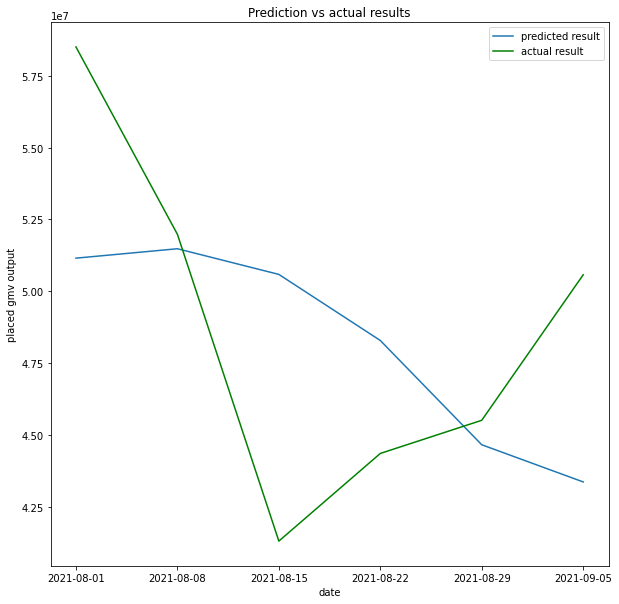

In [9]:
plt.figure(figsize=(10, 10))

plt.plot(total['date'], total['pred_gmv'], label='predicted result')
plt.plot(total['date'], total['actual_gmv'], color='green', label='actual result')

plt.title("Prediction vs actual results")
plt.xlabel('date')
plt.ylabel('placed gmv output')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import r2_score

r2_score(test_y, prediction)  

0.46274978689460244

In [11]:
from datetime import datetime, timedelta
import numpy as np

def get_dates(dates, last_date, num_weeks):
    for i in range(num_weeks):
        dates.append((datetime.strptime(last_date, '%Y-%m-%d') + pd.DateOffset(days=7*(i + 1))).strftime('%Y-%m-%d'))       
    return dates

In [12]:
six_dates = pd.DataFrame(get_dates(list(), '2021-11-07', 6)).rename(columns = {0:'date'})
six_weeks = pd.DataFrame(split_dates(list(), pd.DataFrame(six_dates), 44)).rename(columns = {0:'year', 1:'month', 2:'week'})

pred = pd.DataFrame(svr_rbf.predict(six_weeks)).rename(columns={0: 'placed_gmv'})
pred = pd.DataFrame(scaler.inverse_transform(np.array(getGmv(list(), pred, 6))))
pred = pred.rename(columns={0: 'placed_gmv'}).reset_index()

six_weeks_pred = pred.join(six_dates, lsuffix="", rsuffix="").rename(columns = {0:'placed_gmv'})
six_weeks_pred


index    placed_gmv        date
0      0  2.381880e+07  2021-11-14
1      1  2.489205e+07  2021-11-21
2      2  2.699300e+07  2021-11-28
3      3  2.865641e+07  2021-12-05
4      4  3.113134e+07  2021-12-12
5      5  3.230711e+07  2021-12-19

Text(0, 0.5, 'placed gmv output')

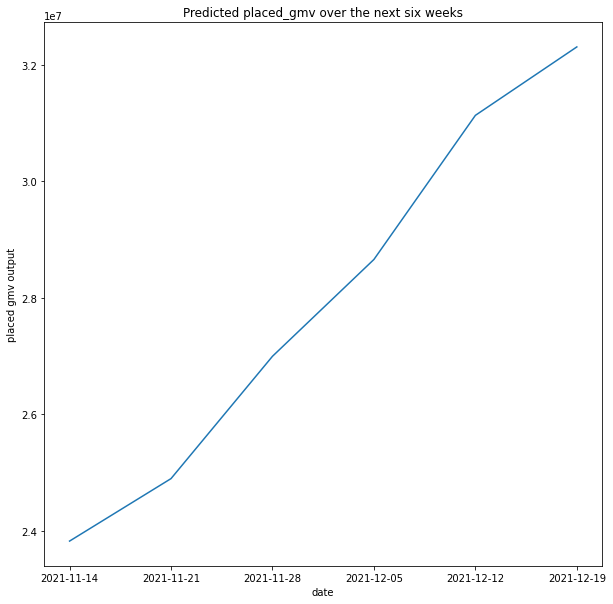

In [13]:
plt.figure(figsize = (10, 10))

plt.plot(six_weeks_pred['date'], six_weeks_pred['placed_gmv'])

plt.title("Predicted placed_gmv over the next six weeks")
plt.xlabel('date')
plt.ylabel('placed gmv output')

In [14]:
twelve_dates = pd.DataFrame(get_dates(list(), '2021-11-07', 12)).rename(columns = {0:'date'})
twelve_weeks = pd.DataFrame(split_dates(list(), pd.DataFrame(twelve_dates), 44)).rename(columns = {0:'year', 1:'month', 2:'week'})

pred = pd.DataFrame(svr_rbf.predict(twelve_weeks)).rename(columns={0: 'placed_gmv'})
pred = pd.DataFrame(scaler.inverse_transform(np.array(getGmv(list(), pred, 12))))
pred = pred.rename(columns={0: 'placed_gmv'}).reset_index()

twelve_weeks_pred = pred.join(twelve_dates, lsuffix="", rsuffix="").rename(columns = {0:'placed_gmv'})
twelve_weeks_pred['placed_gmv'][7] = 0

twelve_weeks_pred

/var/folders/90/7r18t2v525zglth1j82fkxwm0000gn/T/ipykernel_55508/359325446.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twelve_weeks_pred['placed_gmv'][7] = 0


index    placed_gmv        date
0       0  2.381880e+07  2021-11-14
1       1  2.489205e+07  2021-11-21
2       2  2.699300e+07  2021-11-28
3       3  2.865641e+07  2021-12-05
4       4  3.113134e+07  2021-12-12
5       5  3.230711e+07  2021-12-19
6       6  3.130841e+07  2021-12-26
7       7  0.000000e+00  2022-01-02
8       8  5.413259e+06  2022-01-09
9       9  1.726529e+07  2022-01-16
10     10  2.430489e+07  2022-01-23
11     11  2.752051e+07  2022-01-30

Text(0, 0.5, 'placed gmv output')

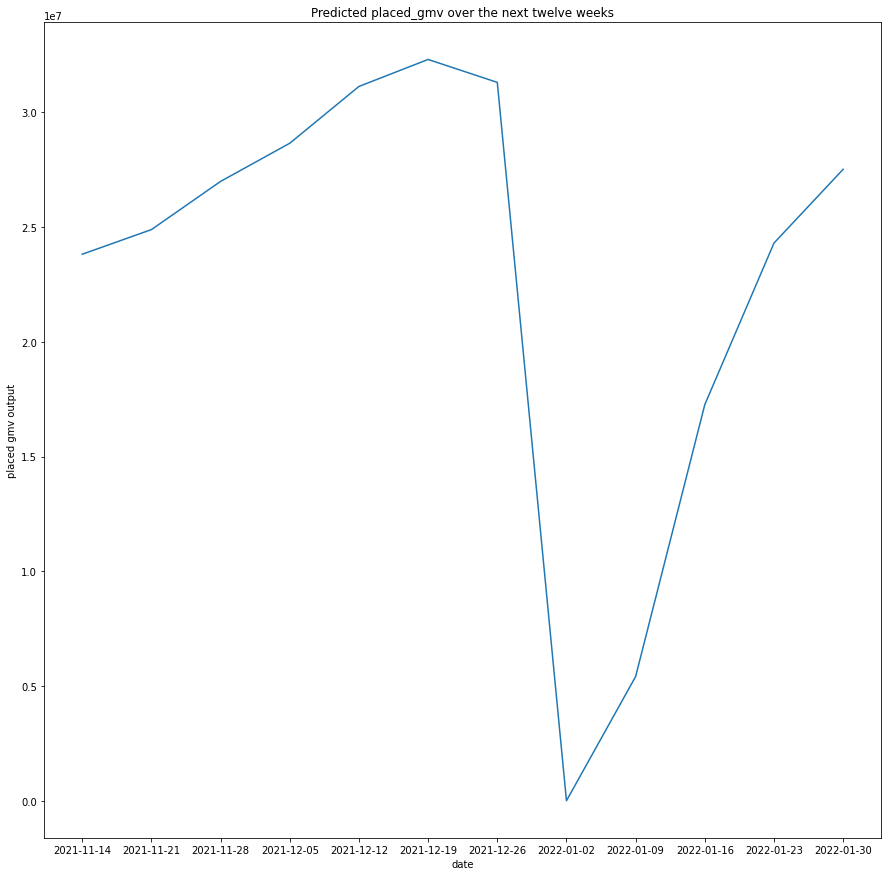

In [15]:
plt.figure(figsize = (15, 15))

plt.plot(twelve_weeks_pred['date'], twelve_weeks_pred['placed_gmv'])

plt.title("Predicted placed_gmv over the next twelve weeks")
plt.xlabel('date')
plt.ylabel('placed gmv output')

In [16]:
holidays_data = pd.read_csv('/Users/ravi57004/Documents/AR_analysis/Data/holidays.csv', index_col = 0)

In [17]:
dates = pd.DataFrame(get_dates(list(), '2021-11-07', 111)).rename(columns = {0:'date'})
weeks = pd.DataFrame(split_dates(list(), pd.DataFrame(dates), 44)).rename(columns = {0:'year', 1:'month', 2:'week'})

pred = pd.DataFrame(svr_rbf.predict(weeks)).rename(columns={0: 'placed_gmv'})
pred = pd.DataFrame(scaler.inverse_transform(np.array(getGmv(list(), pred, 111))))
pred = pred.rename(columns={0: 'placed_gmv'})

pred = pred.join(dates, lsuffix="", rsuffix="").rename(columns = {0:'placed_gmv'})
pred

for i in range(110):
    if pred['placed_gmv'][i] < 0:
        pred['placed_gmv'][i] = 0


/var/folders/90/7r18t2v525zglth1j82fkxwm0000gn/T/ipykernel_55508/975020356.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred['placed_gmv'][i] = 0


In [18]:
holi_list = list()
holi_name = list()

for d in dates['date']:
    if (holidays_data.index.str.contains(d).any()):
        holi_list.append(d)
        holi_name.append(holidays_data.loc[d, 'holiday_name'])
    
holi_list = (pd.DataFrame(holi_list).reset_index()).rename(columns = {0:'date'})
holi_name = (pd.DataFrame(holi_name).reset_index()).rename(columns = {0:'name'})
holidays = holi_list.merge(holi_name)

holidays = pred.merge(holidays)

holidays

placed_gmv        date  index                                  name
0  2.430489e+07  2022-01-23      0         first philippine republic day
1  4.943826e+07  2022-05-01      1                             labor day
2  5.614642e+07  2022-06-12      2                      independence day
3  7.017166e+07  2022-07-10      3  eid al-adha (feast of the sacrifice)
4  7.415563e+07  2022-08-21      4                      ninoy aquino day
5  3.045851e+07  2022-12-25      5                         christmas day
6  0.000000e+00  2023-01-01      6                        new year's day
7  1.881128e+07  2023-01-22      7          chinese lunar new year's day
8  5.890231e+07  2023-04-09      8                      the day of valor
9  7.992835e+07  2023-09-03      9               yamashita surrender day

In [19]:
payday_list = list()

for d in dates['date']:
    if ('15' in d or '30' in d):
        payday_list.append(d)
        
payday = (pd.DataFrame(payday_list).reset_index()).rename(columns = {0:'date'})

payday = pred.merge(payday)

payday

placed_gmv        date  index
0  2.752051e+07  2022-01-30      0
1  5.389110e+07  2022-05-15      1
2  2.363802e+07  2022-10-30      2
3  9.406064e+06  2023-01-15      3
4  6.561792e+07  2023-04-30      4
5  1.061788e+08  2023-07-30      5
6  3.264662e+07  2023-10-15      6

/var/folders/90/7r18t2v525zglth1j82fkxwm0000gn/T/ipykernel_55508/3548397956.py:16: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks(())


Text(0.5, 1.0, 'Gmv performance over the next 2 years')

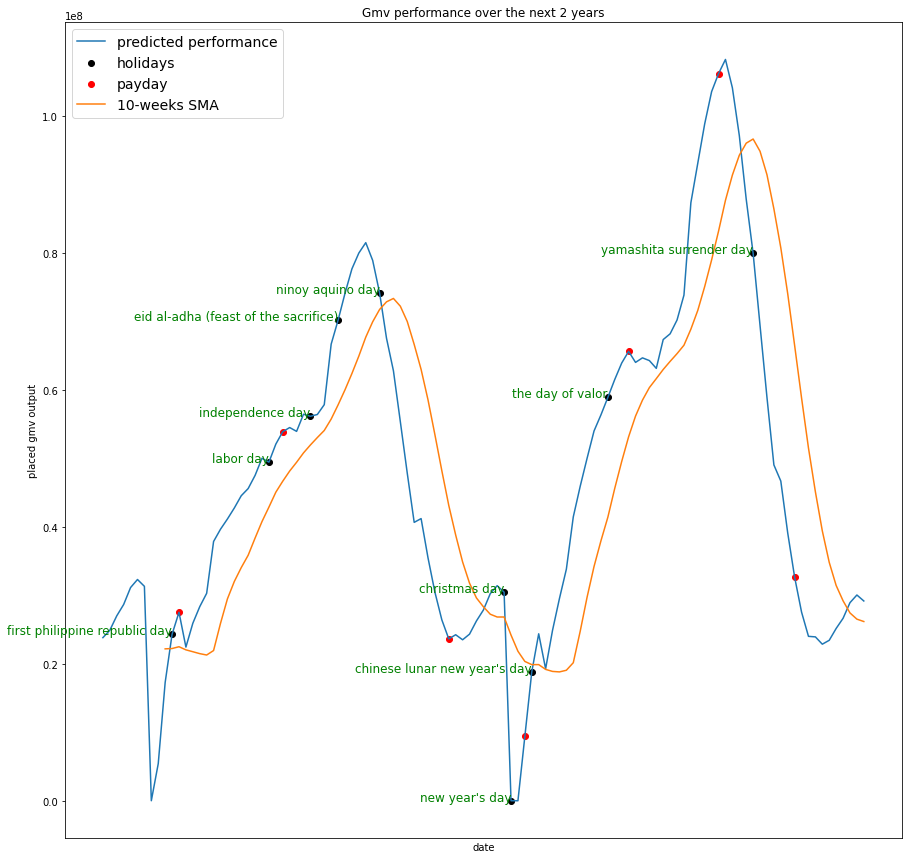

In [20]:
plt.figure(figsize = (15, 15))

plt.plot(pred['date'], pred['placed_gmv'])
plt.scatter(holidays['date'],  holidays['placed_gmv'], color='black')
plt.scatter(payday['date'],  payday['placed_gmv'], color='red')

for line in range(0, holidays.shape[0]):
     plt.text(holidays['date'][line], holidays['placed_gmv'][line] + 0.1, 
     holidays['name'][line], horizontalalignment='right', 
     size='large', color='green', weight='normal') 
        
moving_avg = pred['placed_gmv'].rolling(window =10).mean().plot()
plt.legend(labels =['predicted performance','holidays', 'payday', '10-weeks SMA'], fontsize=14)      
    
    
plt.xticks(())
plt.xlabel('date')
plt.ylabel('placed gmv output')
plt.title("Gmv performance over the next 2 years")